# Components of StyleGAN

### Goals
In this notebook, you're going to implement various components of StyleGAN, including the truncation trick, the mapping layer, noise injection, adaptive instance normalization (AdaIN), and progressive growing. 

### Learning Objectives

1.   Understand the components of StyleGAN that differ from the traditional GAN.
2.   Implement the components of StyleGAN.




## Getting Started
You will begin by importing some packages from PyTorch and defining a visualization function which will be useful later.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## Truncation Trick
The first component you will implement is the truncation trick. Remember that this is done after the model is trained and when you are sampling beautiful outputs. The truncation trick resamples the noise vector $z$ from a truncated normal distribution which allows you to tune the generator's fidelity/diversity. The truncation value is at least 0, where 1 means there is little truncation (high diversity) and 0 means the distribution is all truncated except for the mean (high quality/fidelity). This trick is not exclusive to StyleGAN. In fact, you may recall playing with it in an earlier GAN notebook.

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: get_truncated_noise

from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

In [3]:
# Test the truncation sample
assert tuple(get_truncated_noise(n_samples=10, z_dim=5, truncation=0.7).shape) == (10, 5)
simple_noise = get_truncated_noise(n_samples=1000, z_dim=10, truncation=0.2)
assert simple_noise.max() > 0.199 and simple_noise.max() < 2
assert simple_noise.min() < -0.199 and simple_noise.min() > -0.2
assert simple_noise.std() > 0.113 and simple_noise.std() < 0.117
print("Success!")

Success!


## Mapping $z$ → $w$

The next component you need to implement is the mapping network. It takes the noise vector, $z$, and maps it to an intermediate noise vector, $w$. This makes it so $z$ can be represented in a more disentangled space which makes the features easier to control later.

The mapping network in StyleGAN is composed of 8 layers, but for your implementation, you will use a neural network with 3 layers. This is to save time training later.

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">MappingLayers</font></code></b>
</font>
</summary>

1.   This code should be five lines.
2.   You need 3 linear layers and should use ReLU activations.
3.   Your linear layers should be input -> hidden_dim -> hidden_dim -> output.
</details>

In [4]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: MappingLayers

class MappingLayers(nn.Module):
    '''
    Mapping Layers Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        hidden_dim: the inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            # Please write a neural network which takes in tensors of 
            # shape (n_samples, z_dim) and outputs (n_samples, w_dim)
            # with a hidden layer with hidden_dim neurons
            #### START CODE HERE ####
            #### START CODE HERE ####
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
            #### END CODE HERE ####
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of MappingLayers: 
        Given an initial noise tensor, returns the intermediate noise tensor.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.mapping(noise)
    
    #UNIT TEST COMMENT: Required for grading
    def get_mapping(self):
        return self.mapping

In [5]:
# Test the mapping function
map_fn = MappingLayers(10,20,30)
assert tuple(map_fn(torch.randn(2, 10)).shape) == (2, 30)
assert len(map_fn.mapping) > 4
outputs = map_fn(torch.randn(1000, 10))
assert outputs.std() > 0.05 and outputs.std() < 0.3
assert outputs.min() > -2 and outputs.min() < 0
assert outputs.max() < 2 and outputs.max() > 0
layers = [str(x).replace(' ', '').replace('inplace=True', '') for x in map_fn.get_mapping()]
assert layers == ['Linear(in_features=10,out_features=20,bias=True)', 
                  'ReLU()', 
                  'Linear(in_features=20,out_features=20,bias=True)', 
                  'ReLU()', 
                  'Linear(in_features=20,out_features=30,bias=True)']
print("Success!")

Success!


## Random Noise Injection
Next, you will implement the random noise injection that occurs before every AdaIN block. To do this, you need to create a noise tensor that is the same size as the current feature map (image).

The noise tensor is not entirely random; it is initialized as one random channel that is then multiplied by learned weights for each channel in the image. For example, imagine an image has 512 channels and its height and width are (4 x 4). You would first create a random (4 x 4) noise matrix with one channel. Then, your model would create 512 values—one for each channel. Next, you multiply the (4 x 4) matrix by each one of these values. This creates a "random" tensor of 512 channels and (4 x 4) pixels, the same dimensions as the image. Finally, you add this noise tensor to the image. This introduces uncorrelated noise and is meant to increase the diversity in the image.

New starting weights are generated for every new layer, or generator, where this class is used. Within a layer, every following time the noise injection is called, you take another step with the optimizer and the weights that you use for each channel are optimized (i.e. learned).

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">InjectNoise</font></code></b>
</font>
</summary>

1.   The weight should have the shape (1, channels, 1, 1).
</details>

<!-- <details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">InjectNoise</font></code></b>
</font>
</summary>

1.   Remember that you only make the noise for one channel (it is then multiplied by random values to create ones for the other channels).
</details> -->

<!-- (not sure how??) You'll find the get_noise function from before helpful here -->

In [7]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: InjectNoise

class InjectNoise(nn.Module):
    '''
    Inject Noise Class
    Values:
        channels: the number of channels the image has, a scalar
    '''
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter( # You use nn.Parameter so that these weights can be optimized
            # Initiate the weights for the channels from a random normal distribution
            #### START CODE HERE ####
            torch.randn(1, channels, 1, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of InjectNoise: Given an image, 
        returns the image with random noise added.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
        '''
        # Set the appropriate shape for the noise!
        
       
        #### START CODE HERE ####
        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])
        #### END CODE HERE ####
        
        noise = torch.randn(noise_shape, device=image.device) # Creates the random noise
        return image + self.weight * noise # Applies to image after multiplying by the weight for each channel
    
    #UNIT TEST COMMENT: Required for grading
    def get_weight(self):
        return self.weight
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self
    

In [8]:
# UNIT TEST
test_noise_channels = 3000
test_noise_samples = 20
fake_images = torch.randn(test_noise_samples, test_noise_channels, 10, 10)
inject_noise = InjectNoise(test_noise_channels)
assert torch.abs(inject_noise.weight.std() - 1) < 0.1
assert torch.abs(inject_noise.weight.mean()) < 0.1
assert type(inject_noise.get_weight()) == torch.nn.parameter.Parameter

assert tuple(inject_noise.weight.shape) == (1, test_noise_channels, 1, 1)
inject_noise.weight = nn.Parameter(torch.ones_like(inject_noise.weight))
# Check that something changed
assert torch.abs((inject_noise(fake_images) - fake_images)).mean() > 0.1
# Check that the change is per-channel
assert torch.abs((inject_noise(fake_images) - fake_images).std(0)).mean() > 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(1)).mean() < 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(2)).mean() > 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(3)).mean() > 1e-4
# Check that the per-channel change is roughly normal
per_channel_change = (inject_noise(fake_images) - fake_images).mean(1).std()
assert per_channel_change > 0.9 and per_channel_change < 1.1
# Make sure that the weights are being used at all
inject_noise.weight = nn.Parameter(torch.zeros_like(inject_noise.weight))
assert torch.abs((inject_noise(fake_images) - fake_images)).mean() < 1e-4
assert len(inject_noise.weight.shape) == 4
print("Success!")

Success!


## Adaptive Instance Normalization (AdaIN)
The next component you will implement is AdaIN. To increase control over the image, you inject $w$ — the intermediate noise vector — multiple times throughout StyleGAN. This is done by transforming it into a set of style parameters and introducing the style to the image through AdaIN. Given an image ($x_i$) and the intermediate vector ($w$), AdaIN takes the instance normalization of the image and multiplies it by the style scale ($y_s$) and adds the style bias ($y_b$). You need to calculate the learnable style scale and bias by using linear mappings from $w$.

# $ \text{AdaIN}(\boldsymbol{\mathrm{x}}_i, \boldsymbol{\mathrm{y}}) = \boldsymbol{\mathrm{y}}_{s,i} \frac{\boldsymbol{\mathrm{x}}_i - \mu(\boldsymbol{\mathrm{x}}_i)}{\sigma(\boldsymbol{\mathrm{x}}_i)} + \boldsymbol{\mathrm{y}}_{b,i} $

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">forward</font></code></b>
</font>
</summary>

1.   Remember the equation for AdaIN.
2.   The instance normalized image, style scale, and style shift have already been calculated for you.
</details>

In [10]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: AdaIN

class AdaIN(nn.Module):
    '''
    AdaIN Class
    Values:
        channels: the number of channels the image has, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        # Normalize the input per-dimension
        self.instance_norm = nn.InstanceNorm2d(channels)

        # You want to map w to a set of style weights per channel.
        # Replace the Nones with the correct dimensions - keep in mind that 
        # both linear maps transform a w vector into style weights 
        # corresponding to the number of image channels.
        #### START CODE HERE ####
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)
        #### END CODE HERE ####

    def forward(self, image, w):
        '''
        Function for completing a forward pass of AdaIN: Given an image and intermediate noise vector w, 
        returns the normalized image that has been scaled and shifted by the style.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        
        # Calculate the transformed image
        #### START CODE HERE ####
        transformed_image = style_scale * normalized_image + style_shift
        #### END CODE HERE ####
        return transformed_image
    
    #UNIT TEST COMMENT: Required for grading
    def get_style_scale_transform(self):
        return self.style_scale_transform
    
    #UNIT TEST COMMENT: Required for grading
    def get_style_shift_transform(self):
        return self.style_shift_transform
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self 


In [11]:
w_channels = 50
image_channels = 20
image_size = 30
n_test = 10
adain = AdaIN(image_channels, w_channels)
test_w = torch.randn(n_test, w_channels)
assert adain.style_scale_transform(test_w).shape == adain.style_shift_transform(test_w).shape
assert adain.style_scale_transform(test_w).shape[-1] == image_channels
assert tuple(adain(torch.randn(n_test, image_channels, image_size, image_size), test_w).shape) == (n_test, image_channels, image_size, image_size)

w_channels = 3
image_channels = 2
image_size = 3
n_test = 1
adain = AdaIN(image_channels, w_channels)

adain.style_scale_transform.weight.data = torch.ones_like(adain.style_scale_transform.weight.data) / 4
adain.style_scale_transform.bias.data = torch.zeros_like(adain.style_scale_transform.bias.data)
adain.style_shift_transform.weight.data = torch.ones_like(adain.style_shift_transform.weight.data) / 5
adain.style_shift_transform.bias.data = torch.zeros_like(adain.style_shift_transform.bias.data)
test_input = torch.ones(n_test, image_channels, image_size, image_size)
test_input[:, :, 0] = 0
test_w = torch.ones(n_test, w_channels)
test_output = adain(test_input, test_w)
assert(torch.abs(test_output[0, 0, 0, 0] - 3 / 5 + torch.sqrt(torch.tensor(9 / 8))) < 1e-4)
assert(torch.abs(test_output[0, 0, 1, 0] - 3 / 5 - torch.sqrt(torch.tensor(9 / 32))) < 1e-4)
print("Success!")

Success!


## Progressive Growing in StyleGAN
The final StyleGAN component that you will create is progressive growing. This helps StyleGAN to create high resolution images by gradually doubling the image's size until the desired size.

You will start by creating a block for the StyleGAN generator. This is comprised of an upsampling layer, a convolutional layer, random noise injection, an AdaIN layer, and an activation.

In [12]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: MicroStyleGANGeneratorBlock

class MicroStyleGANGeneratorBlock(nn.Module):
    '''
    Micro StyleGAN Generator Block Class
    Values:
        in_chan: the number of channels in the input, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        kernel_size: the size of the convolving kernel
        starting_size: the size of the starting image
    '''

    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample
        # Replace the Nones in order to:
        # 1. Upsample to the starting_size, bilinearly (https://pytorch.org/docs/master/generated/torch.nn.Upsample.html)
        # 2. Create a kernel_size convolution which takes in 
        #    an image with in_chan and outputs one with out_chan (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
        # 3. Create an object to inject noise
        # 4. Create an AdaIN object
        # 5. Create a LeakyReLU activation with slope 0.2
        
        #### START CODE HERE ####
        if self.use_upsample:
            self.upsample = nn.Upsample((starting_size, starting_size), mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) # Padding is used to maintain the image size
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)
        #### END CODE HERE ####

    def forward(self, x, w):
        '''
        Function for completing a forward pass of MicroStyleGANGeneratorBlock: Given an x and w, 
        computes a StyleGAN generator block.
        Parameters:
            x: the input into the generator, feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self;

In [13]:
test_stylegan_block = MicroStyleGANGeneratorBlock(in_chan=128, out_chan=64, w_dim=256, kernel_size=3, starting_size=8)
test_x = torch.ones(1, 128, 4, 4)
test_x[:, :, 1:3, 1:3] = 0
test_w = torch.ones(1, 256)
test_x = test_stylegan_block.upsample(test_x)
assert tuple(test_x.shape) == (1, 128, 8, 8)
assert torch.abs(test_x.mean() - 0.75) < 1e-4
test_x = test_stylegan_block.conv(test_x)
assert tuple(test_x.shape) == (1, 64, 8, 8)
test_x = test_stylegan_block.inject_noise(test_x)
test_x = test_stylegan_block.activation(test_x)
assert test_x.min() < 0
assert -test_x.min() / test_x.max() < 0.4
test_x = test_stylegan_block.adain(test_x, test_w) 
foo = test_stylegan_block(torch.ones(10, 128, 4, 4), torch.ones(10, 256))

print("Success!")

Success!


Now, you can implement progressive growing. 

StyleGAN starts with a constant 4 x 4 (x 512 channel) tensor which is put through an iteration of the generator without upsampling. The output is some noise that can then be transformed into a blurry 4 x 4 image. This is where the progressive growing process begins. The 4 x 4 noise can be further passed through a generator block with upsampling to produce an 8 x 8 output. However, this will be done gradually.

You will simulate progressive growing from an 8 x 8 image to a 16 x 16 image. Instead of simply passing it to the generator block with upsampling, StyleGAN gradually trains the generator to the new size by mixing in an image that was only upsampled. By mixing an upsampled 8 x 8 image (which is 16 x 16) with increasingly more of the 16 x 16 generator output, the generator is more stable as it progressively trains. As such, you will do two separate operations with the 8 x 8 noise:

1.   Pass it into the next generator block to create an output noise, that you will then transform to an image.
2.   Transform it into an image and then upsample it to be 16 x 16.

You will now have two images that are both double the resolution of the 8 x 8 noise. Then, using an alpha ($\alpha$) term, you combine the higher resolution images obtained from (1) and (2). You would then pass this into the discriminator and use the feedback to update the weights of your generator. The key here is that the $\alpha$ term is gradually increased until eventually, only the image from (1), the generator, is used. That is your final image or you could continue this process to make a 32 x 32 image or 64 x 64, 128 x 128, etc. 

This micro model you will implement will visualize what the model outputs at a particular stage of training, for a specific value of $\alpha$. However to reiterate, in practice, StyleGAN will slowly phase out the upsampled image by increasing the $\alpha$ parameter over many training steps, doing this process repeatedly with larger and larger alpha values until it is 1—at this point, the combined image is solely comprised of the image from the generator block. This method of gradually training the generator increases the stability and fidelity of the model.

<!-- by passing a random noise vector in $z$ through the mapping function you wrote to get $w$. $w$ is then passed through the first block of the generator to create your first output noise. -->

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">forward</font></code></b>
</font>
</summary>

1.    You may find [torch.lerp](https://pytorch.org/docs/stable/generated/torch.lerp.html) helpful.

</details>

In [14]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: MicroStyleGANGenerator

class MicroStyleGANGenerator(nn.Module):
    '''
    Micro StyleGAN Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        map_hidden_dim: the mapping inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        in_chan: the dimension of the constant input, usually w_dim, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        kernel_size: the size of the convolving kernel
        hidden_chan: the inner dimension, a scalar
    '''

    def __init__(self, 
                 z_dim, 
                 map_hidden_dim,
                 w_dim,
                 in_chan,
                 out_chan, 
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        # Typically this constant is initiated to all ones, but you will initiate to a
        # Gaussian to better visualize the network's effect
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        self.block0 = MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)
        self.block1 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8)
        self.block2 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16)
        # You need to have a way of mapping from the output noise to an image, 
        # so you learn a 1x1 convolution to transform the e.g. 512 channels into 3 channels
        # (Note that this is simplified, with clipping used in the real StyleGAN)
        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.alpha = 0.2

    def upsample_to_match_size(self, smaller_image, bigger_image):
        '''
        Function for upsampling an image to the size of another: Given a two images (smaller and bigger), 
        upsamples the first to have the same dimensions as the second.
        Parameters:
            smaller_image: the smaller image to upsample
            bigger_image: the bigger image whose dimensions will be upsampled to
        '''
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        '''
        Function for completing a forward pass of MicroStyleGANGenerator: Given noise, 
        computes a StyleGAN iteration.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
            return_intermediate: a boolean, true to return the images as well (for testing) and false otherwise
        '''
        x = self.starting_constant
        w = self.map(noise)
        x = self.block0(x, w)
        x_small = self.block1(x, w) # First generator run output
        x_small_image = self.block1_to_image(x_small)
        x_big = self.block2(x_small, w) # Second generator run output 
        x_big_image = self.block2_to_image(x_big)
        x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image) # Upsample first generator run output to be same size as second generator run output 
        # Interpolate between the upsampled image and the image from the generator using alpha
        
        #### START CODE HERE ####
        interpolation =  self.alpha * (x_big_image) + (1-self.alpha) * (x_small_upsample)
        #### END CODE HERE #### 
        
        if return_intermediate:
            return interpolation, x_small_upsample, x_big_image
        return interpolation
    
    #UNIT TEST COMMENT: Required for grading
    def get_self(self):
        return self;

In [15]:
z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
)

test_samples = 10
test_result = mu_stylegan(get_truncated_noise(test_samples, z_dim, truncation))

# Check if the block works
assert tuple(test_result.shape) == (test_samples, out_chan, 16, 16)

# Check that the interpolation is correct
mu_stylegan.alpha = 1.
test_result, _, test_big =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_big).mean() < 0.001
mu_stylegan.alpha = 0.
test_result, test_small, _ =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_small).mean() < 0.001
print("Success!")

Success!


## Running StyleGAN
Finally, you can put all the components together to run an iteration of your micro StyleGAN!

You can also visualize what this randomly initiated generator can produce. The code will automatically interpolate between different values of alpha so that you can intuitively see what it means to mix the low-resolution and high-resolution images using different values of alpha. In the generated image, the samples start from low alpha values and go to high alpha values.

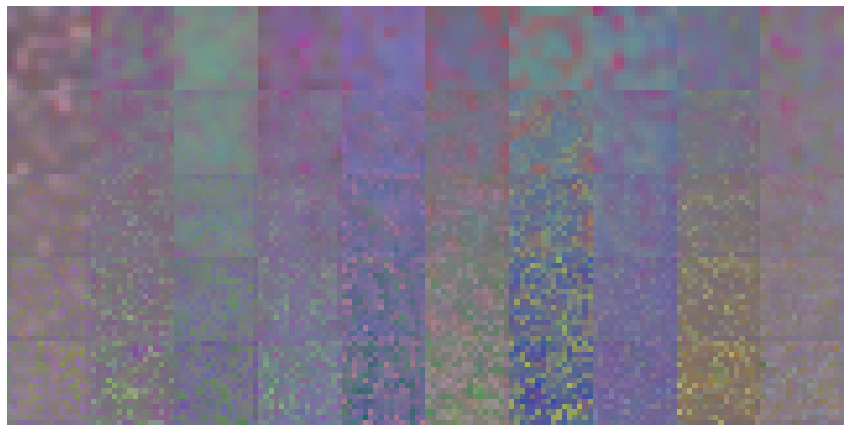

In [16]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
# The noise is exaggerated for visual effect
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise, 
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
mu_stylegan = mu_stylegan.train()